Are the contaminants being injected into the water column within the Salish Sea Atlantis Model within a timescale of 10 days as we might expect? 

How about uptake by the phytoplankton?

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

### Package and file imports

In [1]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import ssam_groups as groups

In [2]:
control_name = '_'
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/"+ control_name + "/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)

In [3]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Tests/')
scenario_paths = sorted([p for p in scenario_root.glob('7a*/outputSalishSea.nc')])
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [17]:
for scenario in scenario_datasets:
    time = np.ma.filled(scenario.variables['t'], np.nan)

In [4]:
scenario_labels = []
for path in scenario_paths:
    scenario_labels.append(path.parent.stem)

In [32]:
def plot_group(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tbl = np.ma.filled(scenario.variables[variable], np.nan)
            volume_tbl = np.ma.filled(scenario.volume, np.nan)
            contam_mass_tbl = contam_tbl * volume_tbl
            contam_mass_tb = contam_mass_tbl.sum(axis=2)
            contam_mass_t = contam_mass_tb.sum(axis=1)
            ax.plot(time[0:167], contam_mass_t[0:167])
        ax.legend(group,  loc='upper left')
        ax.set_ylabel('mg')
        ax.set_title(nm)

In [40]:
def compare_scenario_pah(species, pah, boxes=groups.salish_sea):
    fig, ax = plt.subplots(figsize = (14,3))
    names = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        names.append(path.parent.stem)
        contam_tbl = np.ma.filled(scenario.variables[species+'_' + pah][:,boxes,:], np.nan)
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,boxes,:], np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)
        ax.plot(time, contam_mass_t)
    ax.legend(names)
    ax.set_ylabel(species + ' PAH (mg)')
    ax.set_title(pah, fontsize = 12);

In [43]:
def print_max_pah_mass(species, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        for pah in groups.pahs:
            contam_tbl = np.ma.filled(scenario.variables[species +'_'+ pah], np.nan)
            volume_tbl = np.ma.filled(scenario.variables['volume'], np.nan)
            contam_mass_tbl = contam_tbl * volume_tbl
            contam_mass_tb = contam_mass_tbl.sum(axis=2)
            contam_mass_t = contam_mass_tb.sum(axis=1)
            max_contam_mass = contam_mass_t.max()
            print(path.parent.stem, species, pah, max_contam_mass)

### Water Column - without resets

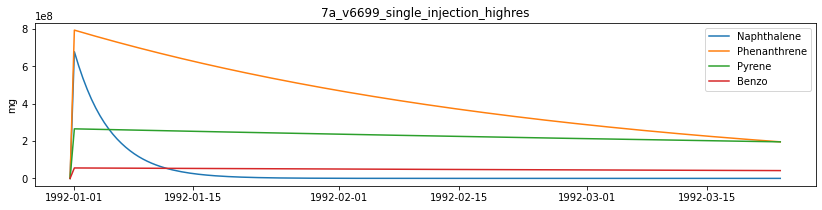

In [18]:
plot_group(groups.pahs, scenario_datasets, scenario_paths)

### Biology

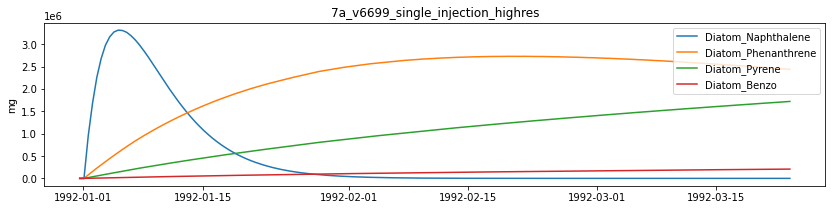

In [28]:
new_group = {}
for pah in groups.pahs:
    new_group['Diatom_'+pah]= 'Diatom_' +pah
plot_group(new_group, scenario_datasets, scenario_paths)

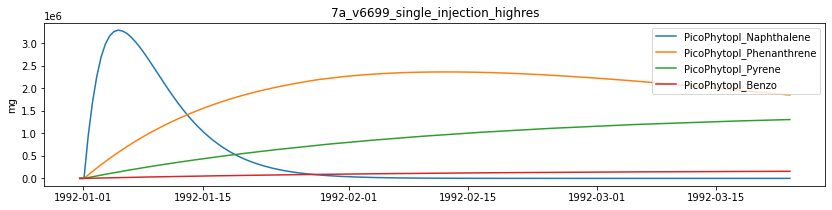

In [29]:
new_group = {}
for pah in groups.pahs:
    new_group['PicoPhytopl_'+pah]= 'PicoPhytopl_' +pah
plot_group(new_group, scenario_datasets, scenario_paths)

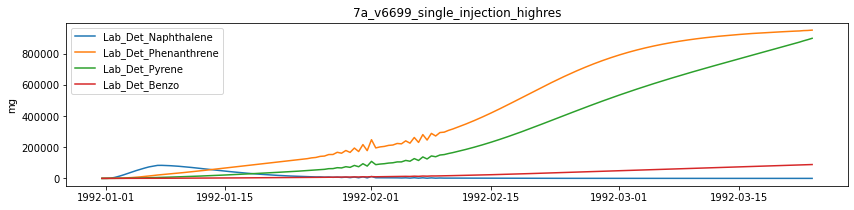

In [33]:
new_group = {}
for pah in groups.pahs:
    new_group['Lab_Det_'+pah]= 'Lab_Det_' +pah
plot_group(new_group, scenario_datasets, scenario_paths)

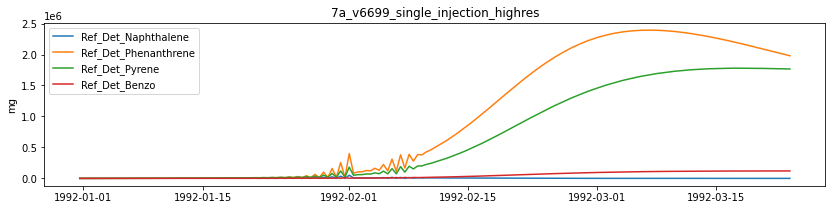

In [34]:
new_group = {}
for pah in groups.pahs:
    new_group['Ref_Det_'+pah]= 'Ref_Det_' +pah
plot_group(new_group, scenario_datasets, scenario_paths)

In [ ]:
for pah in groups.pahs:
    compare_scenario_pah('Ref_Det',pah)

In [44]:
print_max_pah_mass('Ref_Det', scenario_datasets, scenario_paths)

7a_v6699_single_injection_highres Ref_Det Naphthalene 50299.126807270484
7a_v6699_single_injection_highres Ref_Det Phenanthrene 2393725.8896885756
7a_v6699_single_injection_highres Ref_Det Pyrene 1780213.8191496527
7a_v6699_single_injection_highres Ref_Det Benzo 120364.02518222455


In [47]:
max_Ref_Det_Phe_percent = (2393725/2.65e8)*100
max_Ref_Det_Phe_percent

0.9032924528301887

In [48]:
print_max_pah_mass('Lab_Det', scenario_datasets, scenario_paths)

7a_v6699_single_injection_highres Lab_Det Naphthalene 83587.9395031035
7a_v6699_single_injection_highres Lab_Det Phenanthrene 965369.285490634
7a_v6699_single_injection_highres Lab_Det Pyrene 1012503.3539265676
7a_v6699_single_injection_highres Lab_Det Benzo 102603.18043485886
